# Imports

In [7]:
import os
import random
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

<h1>Read Data</h1>

In [2]:
path = "aclImdb/"
'''train_positive_files=[]
for file in os.listdir(path+"train/pos/"):
    train_positive_files.append(file)
'''
train_positive_files = [i for i in os.listdir(path+"train/pos/")]
train_negative_files = [i for i in os.listdir(path+"train/neg/")]


test_positive_files = [i for i in os.listdir(path+"test/pos/")]
test_negative_files = [i for i in os.listdir(path+"test/neg/")]

positive_reviews_train, negative_reviews_train,positive_reviews_test, negative_reviews_test = [], [], [], []

for pfile in train_positive_files :
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        positive_reviews_train.append(f.read())
for nfile in train_negative_files:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        negative_reviews_train.append(f.read())
        
for pfile in test_positive_files :
    with open(path+"test/pos/"+pfile, encoding="latin1") as f:
        positive_reviews_test.append(f.read())
for nfile in test_negative_files:
    with open(path+"test/neg/"+nfile, encoding="latin1") as f:
        negative_reviews_test.append(f.read())

reviews_train = pd.concat([
    pd.DataFrame({"review":positive_reviews_train, "label":1}),
    pd.DataFrame({"review":negative_reviews_train, "label":0}),
], ignore_index=True).sample(frac=1, random_state=1)
    
reviews_test = pd.concat([
    pd.DataFrame({"review":positive_reviews_test, "label":1}),
    pd.DataFrame({"review":negative_reviews_test, "label":0}),
], ignore_index=True).sample(frac=1, random_state=1)

In [3]:
import re # import regular expression package
from contractions import contractions

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]") # patterns to replace with no space

REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)") # patterns to replace with white spaces

# method to process reviews
def process_reviews(reviews):

    for w in contractions:
        reviews = reviews.replace(w, contractions[w])    
        
    reviews = reviews.replace(["[.;:!\'?,\"()\[\]]"], [""], regex=True)
    
    reviews = reviews.replace(["(<br\s*/><br\s*/>)|(\-)|(\/)"], [" "], regex=True)

    return reviews

# cleaned training dataset.
reviews_train_clean = process_reviews(reviews_train)

# cleaned testing dataset
reviews_test_clean = process_reviews(reviews_test)

In [4]:
X_train=reviews_train_clean.iloc[:, 0]
Y_train=reviews_train_clean.iloc[:, 1]
X_test=reviews_test_clean.iloc[:, 0]
Y_test=reviews_test_clean.iloc[:, 1]

<h1>Vectorization</h1>

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer # import Tfidf Vectorizer from sklearn.

stop_words = ['in', 'of', 'at', 'a', 'the']
cv = TfidfVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words) # instantiate counter vector with binary flag set to true.

cv.fit(X_train) # fits the vocabulary.

X_train = cv.transform(X_train) # transforms the document into document-matrix using the fitted vocabulary.

X_test = cv.transform(X_test)

<h1>Build Model</h1>

<h2>Logistic Regression</h2>

In [6]:
from sklearn.linear_model import LogisticRegression

for c in [0.01, 0.05, 0.25, 0.5, 1]:

    lr = LogisticRegression(C=c)

    lr.fit(X_train, Y_train)

    print ("Accuracy for C=%s: %s" % (c, accuracy_score(Y_test, lr.predict(X_test))))
    

C:\Users\rubal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.85472
Accuracy for C=0.05: 0.85928
Accuracy for C=0.25: 0.8732
Accuracy for C=0.5: 0.88064
Accuracy for C=1: 0.88896


In [7]:
final_model_lr = LogisticRegression(C=1)
final_model_lr.fit(X_train, Y_train)

lr_pred = final_model_lr.predict(X_test)

<h2>SVM</h2>

In [9]:
for c in [0.01, 0.05, 0.25, 0.5, 1, 1.05]:
    svm = LinearSVC(C=c)
    svm.fit(X_train, Y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(Y_test, svm.predict(X_test))))

Accuracy for C=0.01: 0.86224
Accuracy for C=0.05: 0.87948
Accuracy for C=0.25: 0.89948
Accuracy for C=0.5: 0.90492
Accuracy for C=1: 0.90724
Accuracy for C=1.05: 0.90716


In [10]:
final_svm = LinearSVC(C=1)
final_svm.fit(X_train, Y_train)

svm_pred = final_svm.predict(X_test)

<h2>Random Forest Refressor</h2>

In [10]:
#from sklearn.model_selection import GridSearchCV
# defining set of hyper-parameters
'''grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'max_depth': [5, 10, 15],
    'max_features': [None, 'sqrt', 'log2', 'auto']
}

# creating grid search instance to choose from best hyper-parameters
gd_sr = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr.fit(X_train, Y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)'''

"grid_param = {\n    'n_estimators': [100, 300, 500, 800, 1000],\n    'max_depth': [5, 10, 15],\n    'max_features': [None, 'sqrt', 'log2', 'auto']\n}\n\n# creating grid search instance to choose from best hyper-parameters\ngd_sr = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)\ngd_sr.fit(X_train, Y_train)\nbest_parameters = gd_sr.best_params_\nprint(best_parameters)"

In [11]:
rf_reg = RandomForestClassifier(max_depth=15, n_estimators = 500)
rf_reg.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
rf_pred = rf_reg.predict(X_test)

<h1>Evaluate</h1>

<h2>Logistic Regression</h2>

In [13]:
accuracy_score(Y_test, lr_pred)

0.88896

<h2>SVM</h2>

In [12]:
accuracy_score(Y_test, svm_pred)

0.90724

<h2>Random Forest</h2>

In [15]:
accuracy_score(Y_test, rf_pred)

0.8438

<h1>Visualisations</h1>

In [22]:
feature_to_coef = {

    word: coef for word, coef in zip(

        cv.get_feature_names(), final_svm.coef_[0]

    )

}

pos_arr=[]
neg_arr=[]
for best_positive in sorted(

    feature_to_coef.items(), 

    key=lambda x: x[1], 

    reverse=True)[:5]:
    
    pos_arr.extend(best_positive)
    print (best_positive)
    
for best_negative in sorted(

    feature_to_coef.items(), 

    key=lambda x: x[1])[:5]:

    neg_arr.extend(best_negative)
    print (best_negative)

('great', 4.78118121798795)
('excellent', 3.9878579570969688)
('best', 3.2510975264963173)
('perfect', 3.1798380275118143)
('wonderful', 3.0711334803054102)
('worst', -5.928260057874241)
('bad', -5.521375081641591)
('awful', -4.2397671585829615)
('boring', -3.759927413589188)
('poor', -3.710279211566409)


In [23]:
x_axis=[]
x_axis.append(pos_arr[0])
x_axis.append(pos_arr[2])
x_axis.append(pos_arr[4])
x_axis.append(pos_arr[6])
x_axis.append(pos_arr[8])
x_axis
y_axis=[]
y_axis.append(pos_arr[1])
y_axis.append(pos_arr[3])
y_axis.append(pos_arr[5])
y_axis.append(pos_arr[7])
y_axis.append(pos_arr[9])
y_axis

[4.78118121798795,
 3.9878579570969688,
 3.2510975264963173,
 3.1798380275118143,
 3.0711334803054102]

In [24]:
xn_axis=[]
xn_axis.append(neg_arr[0])
xn_axis.append(neg_arr[2])
xn_axis.append(neg_arr[4])
xn_axis.append(neg_arr[6])
xn_axis.append(neg_arr[8])
xn_axis
yn_axis=[]
yn_axis.append(neg_arr[1])
yn_axis.append(neg_arr[3])
yn_axis.append(neg_arr[5])
yn_axis.append(neg_arr[7])
yn_axis.append(neg_arr[9])
yn_axis

[-5.928260057874241,
 -5.521375081641591,
 -4.2397671585829615,
 -3.759927413589188,
 -3.710279211566409]

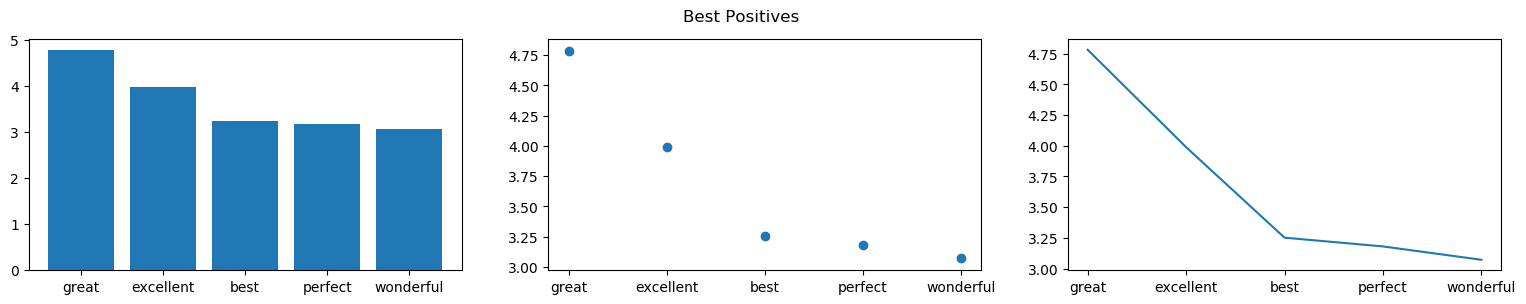

In [25]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(19, 3))

plt.subplot(131)
plt.bar(x_axis, y_axis)
plt.subplot(132)
plt.scatter(x_axis, y_axis)
plt.subplot(133)
plt.plot(x_axis, y_axis)
plt.suptitle('Best Positives')
plt.show()

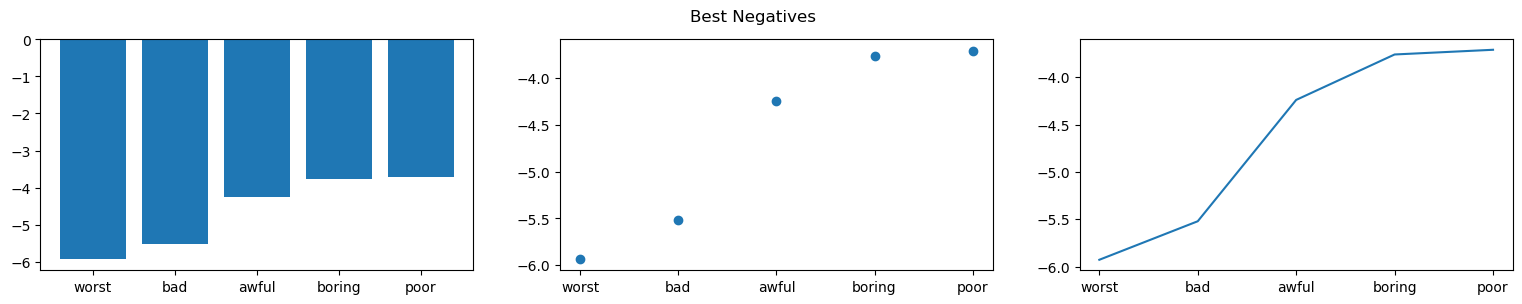

In [26]:
plt.figure(figsize=(19, 3))

plt.subplot(131)
plt.bar(xn_axis, yn_axis)
plt.subplot(132)
plt.scatter(xn_axis, yn_axis)
plt.subplot(133)
plt.plot(xn_axis, yn_axis)
plt.suptitle('Best Negatives')
plt.show()

<h2>Learning Curves</h2>

C:\Users\rubal\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\rubal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


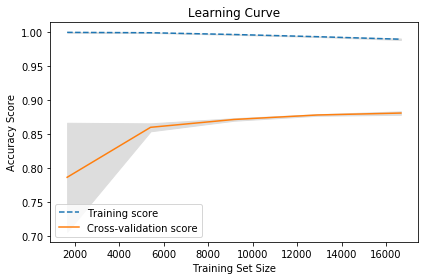

In [19]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), X_train, Y_train)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--',  label="Training score")
plt.plot(train_sizes, test_mean,  label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

C:\Users\rubal\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


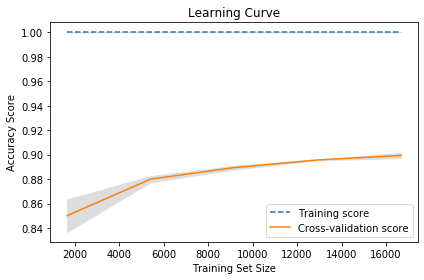

In [20]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LinearSVC(), X_train, Y_train)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--',  label="Training score")
plt.plot(train_sizes, test_mean,  label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

C:\Users\rubal\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\rubal\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rubal\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rubal\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rubal\Anaconda3\lib\site-packages\sklearn\ens

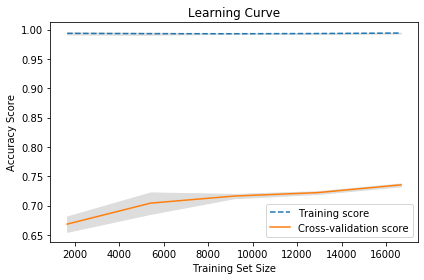

In [21]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_train, Y_train)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--',  label="Training score")
plt.plot(train_sizes, test_mean,  label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [16]:
def predict_sentiment_svm(sent, saved_model):
    sent_cleaned = process_reviews(sent)
    X = cv.transform(sent_cleaned.iloc[:,0])
    #print(X)
    Y_pred = saved_model.predict(X)
    print("\n********** SVM **********")
    if Y_pred[0] == 0:
        print("It has Negative sentiment in it :(")
    else:
        print("It has Positive sentiment in it :)")

In [21]:
def predict_sentiment_lr(sent):
    sent_cleaned = process_reviews(sent)
    X = cv.transform(sent_cleaned.iloc[:,0])
    Y_pred = final_model_lr.predict(X)
    print("\n********** Logistic Regression **********")
    if Y_pred[0] == 0:
        print("It has Negative sentiment in it :(")
    else:
        print("It has Positive sentiment in it :)")

In [22]:
def predict_sentiment_rf(sent):
    sent_cleaned = process_reviews(sent)
    X = cv.transform(sent_cleaned.iloc[:,0])
    Y_pred = rf_reg.predict(X)
    print("\n********** Random Forest **********")
    if Y_pred[0] == 0:
        print("It has Negative sentiment in it :(")
    else:
        print("It has Positive sentiment in it :)")

In [30]:
review = input("Enter the sample review to predict the sentiment out of it \n")

predict_sentiment_svm(pd.DataFrame([[review]]))

#predict_sentiment_lr(pd.DataFrame([[review]]))

#predict_sentiment_rf(pd.DataFrame([[review]]))

Enter the sample review to predict the sentiment out of it 
his is a film I admired more than I liked... I just found the film to be too hyper-staged and too artfully constructed to make an emotional connection

********** SVM **********
It has Positive sentiment in it :)

********** Logistic Regression **********
It has Positive sentiment in it :)

********** Random Forest **********
It has Positive sentiment in it :)


<h1>Saving Modle</h1>

In [13]:
import pickle

filename = 'cap-sentm-imdb.pkl'
pickle.dump(final_svm, open(filename, 'wb')) # saving the final model

In [14]:
saved_model = pickle.load(open(filename, 'rb'))
result = saved_model.score(X_test, Y_test)
print(result)

0.90724


<h1>DEMO</h1>

In [18]:
review = input("Enter the sample review to predict the sentiment out of it \n")

predict_sentiment_svm(pd.DataFrame([[review]]), saved_model)

Enter the sample review to predict the sentiment out of it 
it's not a bad movie

********** SVM **********
It has Negative sentiment in it :(
